In [1]:
# -*- coding: utf-8 -*-
#    Copyright (C) 2022 Maicon Marques Alves (maicon.alves@ufsc.br)
#                       Dirk A. Lorenz (d.lorenz@uni-bremen.de)
#                       Emanuele Naldi (naldi@dima.unige.it)
#
#    This file is part of the example code repository for the paper:
#
#      M. M. Alves, D. A. Lorenz, E. Naldi.
#      A  general framework for inexact splitting algorithms with relative errors and applications to Chambolle-Pock and Davis-Yin methods,
#      2024. https://arxiv.org/pdf/2407.05893
#
#    This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.
#
#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.
#
#    You should have received a copy of the GNU General Public License
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.

"""
This file contains all the experiments in Section 4.1 in:

M. M. Alves, D. A. Lorenz, E. Naldi.
A  general framework for inexact splitting algorithms with relative errors and applications to Chambolle-Pock and Davis-Yin methods,
2024. https://arxiv.org/pdf/2407.05893
"""

In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import time

# function to execute experiment
def experiment1(H,f,lambda_val,maxiter,scale_HPE,sigma_HPE,scale_iCP,scale_CP,filename):
    # precompute H^T f
    HTf = H.T@f
    m,n = H.shape

    # that's how much we will display
    dispiter = maxiter
    # and we will iterate a little longer to get a better estimate of the minimum
    maxiter = maxiter + 200
    
    # helper functions
    def obj(x, lambda_val):
        return np.linalg.norm(np.dot(H, x) - f, 2)**2/2 + lambda_val * np.linalg.norm(np.dot(D, x), 1)

    def shrink(x, beta):
        return np.maximum(np.abs(x) - beta, 0) * np.sign(x)

    def clip(x, beta):
        return np.maximum(np.minimum(x, beta), -beta)

    # how often we want to have output
    check = round(dispiter/10)

    # start HPE for CP
    # stepsizes (theta*tau<1/||D||^2, guaranteed by theta*tau<1/4)
    scale = scale_HPE
    theta = scale * 1/2
    tau = 1/2/scale
    # algorithm parameter
    sigma = sigma_HPE  # (between 0 and 1)

    print('Starting HPE for CP')
    times = np.zeros(maxiter+1)
    objective = np.zeros(maxiter+1)
    itersHPECG = np.zeros(maxiter+1)
    matvecsH_HPE = np.zeros(maxiter+1)
    
    # initialize
    x = np.zeros(n)
    y = np.zeros(n-1)
    objective[0] = obj(x,lambda_val)
    times[0] = 0
    itersHPECG[0] = 0
    matvecsH_HPE[0] = 0

    start = time.time()
    for k in range(maxiter):
        stopped = False
        # here comes the CG iteration
        def A(z):
            return z + tau * np.dot(H.T,np.dot(H, z))
        
        rhs = x - tau * np.dot(D.T, y) + tau * HTf
        # CG init
        xtilde = x  # init for solution
        r = rhs - A(xtilde)  # residual
        p = r  # aux variable
        j = 0  # counter
        while not stopped:
            # one CG step with A = I + lambda*H'*H and right hand side rhs
            Ap = A(p)
            alpha = np.linalg.norm(r, 2)**2 / (p.dot(Ap))
            xtilde = xtilde + alpha * p
            
            # check if stopping criterion fulfilled
            a = (np.dot(H.T,np.dot(H, xtilde)) - HTf)
            DTy = np.dot(D.T, y)
            ytilde = clip(y + theta * np.dot(D, xtilde - tau * (a + DTy)), lambda_val)
            LHS = np.linalg.norm(tau * a + xtilde - (x - tau * DTy))**2 / tau
            RHS = sigma**2 * (np.linalg.norm(xtilde - x)**2 / tau - 2 * (np.dot(D, xtilde - x)).dot(ytilde - y) +
                            np.linalg.norm(ytilde - y)**2 / theta)
            if LHS <= RHS or j > 200:
                stopped = True
                #cgiter = j + 1
            rold = r
            r = r - alpha * Ap
            beta = np.linalg.norm(r, 2)**2 / np.linalg.norm(rold, 2)**2
            p = r + beta * p
            j += 1
        x = x - tau * DTy - tau * a
        y = ytilde
        itersHPECG[k+1] = j
        times[k+1] = time.time() - start
        objective[k+1] = obj(xtilde, lambda_val)
        matvecsH_HPE[k+1] = matvecsH_HPE[k] + j
        if k % check == 0:
            print('k = %d, Obj(ztilde): %f, cgiter: %d' % (k, objective[k+1],itersHPECG[k+1]))

    xHPE = x
    HPE_CP_time = time.time() - start
    print('HPE for CP after %d iterations in %f seconds.' % (k, HPE_CP_time))
    print('Total numbers of CG iterations: %d' % (np.sum(itersHPECG)))
    print('Final objective: %e.\n\n' % objective[-1])

    # start implicit CP
    # stepsizes (theta*tau<1/||D||^2, guaranteed by theta*tau<1/4)
    scale = scale_iCP
    theta = scale * 1/2
    tau = 1/2/scale

    print('Starting implicit CP')
    timesicp = np.zeros(maxiter+1)
    objectiveicp = np.zeros(maxiter+1)
    itersicpCG = np.zeros(maxiter+1)
    matvecsH_icp = np.zeros(maxiter+1)
    # initialize
    x = np.zeros(n)
    y = np.zeros(n-1)


    start = time.time()

    def A(z):
        return z + tau * np.dot(H.T,np.dot(H, z))
    Aop = sc.sparse.linalg.LinearOperator((n,n), matvec=A)
    objectiveicp[0] = obj(x,lambda_val)
    timesicp[0] = time.time() - start
    itersicpCG[0] = 0

    Id = np.eye(n)
    for k in range(maxiter):
        xold = x

        def callback(arr):
            callback.iterations +=1
        callback.iterations = 0
        # x = np.linalg.solve(np.eye(n) + tau*HTH,x + tau*HTf - tau*np.dot(D.T,y) )
        x, info = sc.sparse.linalg.cg(Aop, x + tau*HTf - tau*np.dot(D.T,y), x0=x,tol=1e-8,atol=1e-8,callback=callback)
        y = clip(y + theta*np.dot(D,2*x-xold),lambda_val)

        timesicp[k+1] = time.time() - start
        objectiveicp[k+1] = obj(x, lambda_val)
        itersicpCG[k+1] = callback.iterations
        matvecsH_icp[k+1] = matvecsH_icp[k] + callback.iterations
        if k % check == 0:
            print('k = %d, Obj(ztilde): %f, cgiter: %d' % (k, objective[k+1],itersicpCG[k+1]))

    xiCP = x
    iCP_time = time.time() - start
    print('Implicit CP after %d iterations in %f seconds.' % (k, iCP_time))
    print('Total numbers of CG iterations: %d' % (np.sum(itersicpCG)))
    print('Final objective: %e.\n\n' % objective[-1])

    #################

    # start standard Condat-Vu
    # stepsizes (0<tau<2/||H||^2, ||D||^2 < (1/theta - ||H||^2/2)*1/sigma)
    LQ = np.linalg.norm(H)**2
    tau = 1.9/LQ
    theta = 0.99 * (1/tau - LQ/2) * 1/np.linalg.norm(D)**2


    print('Starting Condat-Vu')
    timescv = np.zeros(maxiter+1)
    objectivecv = np.zeros(maxiter+1)
    matvecsH_cv = np.zeros(maxiter+1)
    # initialize
    x = np.zeros(n)
    y = np.zeros(n-1)
    objectivecv[0] = obj(x,lambda_val)
    timescv[0] = 0
    matvecsH_cv[0] = 0


    start = time.time()
    for k in range(maxiter):
        xold = x
        x = x - tau * (np.dot(H.T,np.dot(H,x)) - HTf+ np.dot(D.T, y))
        y = clip(y + theta * np.dot(D, 2 * x - xold), lambda_val)
        timescv[k+1] = time.time()-start
        objectivecv[k+1] = obj(x, lambda_val)
        matvecsH_cv[k+1] = matvecsH_cv[k] + 1
        if k % check == 0:
            print('k = %d, Obj(xtilde): %f' % (k, objectivecv[k]))

    xCV = x
    CV_time = time.time()-start
    print('CV after %d iterations in %f seconds.' % (k, CV_time))
    print('Final objective: %e.\n\n' % objectivecv[-1])

    # start explicit CP, dualized over both variables
    # stepsizes (theta*tau<1/(||H||^2+||D||^2)
    Norm = np.sqrt(np.linalg.norm(H)**2 + np.linalg.norm(D)**2)
    scale = scale_CP
    theta = scale * 1/Norm
    tau = 1/Norm/scale

    print('Starting explicit CP')
    timescp = np.zeros(maxiter+1)
    objectivecp = np.zeros(maxiter+1)
    matvecsH_cp = np.zeros(maxiter+1)
    # initialize
    x = np.zeros(n)
    u = np.zeros(m)
    v = np.zeros(n-1)
    objectivecp[0] = obj(x,lambda_val)
    timescp[0] = 0
    matvecsH_cp[0] = 0
    

    start = time.time()
    for k in range(maxiter):
        xold = x
        x = x - tau * (np.dot(H.T, u) + np.dot(D.T, v))
        u = (u + theta * np.dot(H, 2 * x - xold) - theta * f) / (1 + theta)
        v = clip(v + theta * np.dot(D, 2 * x - xold), lambda_val)
        timescp[k+1] = time.time() - start
        objectivecp[k+1] = obj(x, lambda_val)
        matvecsH_cp[k+1] = matvecsH_cp[k] + 1
        if k % check == 0:
            print('k = %d, Obj(xtilde): %f' % (k, objectivecp[k]))

    xCP = x
    CP_time = time.time() - start
    print('CP after %d iterations in %f seconds.' % (k, CP_time))
    print('Final objective: %e.\n\n' % objectivecp[-1])

    obj_min = min(np.min(objective),np.min(objectiveicp),np.min(objectivecp),np.min(objectivecv))


    fig1 = plt.figure(1,figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.semilogy(range(1, maxiter + 2), objective-obj_min, range(1, maxiter + 2), objectiveicp-obj_min, range(1, maxiter + 2), objectivecp-obj_min, range(1, maxiter + 2), objectivecv-obj_min)
    plt.xlabel('iterations')
    plt.ylabel('distance to minimal objective')
    plt.xlim(0,dispiter)
    plt.legend(['HPE CP', 'implicit CP', 'explicit CP', 'CV'])


    plt.subplot(1, 2, 2)
    plt.semilogy(matvecsH_HPE[:k], objective[:k]-obj_min, matvecsH_icp[:k], objectiveicp[:k]-obj_min, matvecsH_cp[:k], objectivecp[:k]-obj_min, matvecsH_cv[:k], objectivecv[:k]-obj_min)
    plt.xlabel('number of matvecs with H and H^T')
    plt.ylabel('distance to minimal objective')
    plt.xlim(0,dispiter)
    plt.legend(['HPE CP', 'implicitCP', 'explicit CP', 'CV'])
    
    plt.savefig(f'../{filename}.pdf')

C:\Users\emanu\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Starting HPE for CP
k = 0, Obj(ztilde): 4206.916123, cgiter: 3
k = 300, Obj(ztilde): 60.009113, cgiter: 2
k = 600, Obj(ztilde): 56.349715, cgiter: 2
k = 900, Obj(ztilde): 55.007217, cgiter: 1
k = 1200, Obj(ztilde): 54.564555, cgiter: 1
k = 1500, Obj(ztilde): 54.326969, cgiter: 1
k = 1800, Obj(ztilde): 54.110517, cgiter: 1
k = 2100, Obj(ztilde): 53.867336, cgiter: 1
k = 2400, Obj(ztilde): 53.595121, cgiter: 1
k = 2700, Obj(ztilde): 53.307735, cgiter: 1
k = 3000, Obj(ztilde): 53.015692, cgiter: 1
HPE for CP after 3199 iterations in 49.737526 seconds.
Total numbers of CG iterations: 3981
Final objective: 5.280754e+01.


Starting implicit CP
k = 0, Obj(ztilde): 4206.916123, cgiter: 11
k = 300, Obj(ztilde): 60.009113, cgiter: 6
k = 600, Obj(ztilde): 56.349715, cgiter: 6
k = 900, Obj(ztilde): 55.007217, cgiter: 6
k = 1200, Obj(ztilde): 54.564555, cgiter: 6
k = 1500, Obj(ztilde): 54.326969, cgiter: 6
k = 1800, Obj(ztilde): 54.110517, cgiter: 5
k = 2100, Obj(ztilde): 53.867336, cgiter: 5
k = 2

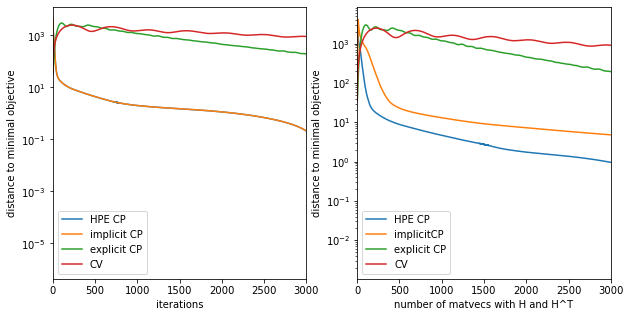

In [3]:
# First experiment

np.random.seed(183763)
# set up the data
m = 2000
n = 2000

# Generate ill conditioned matrix with prescribed spectrum
H = np.random.randn(m,n)
U,S,VT = np.linalg.svd(H)
S = np.zeros((m,n))
xx = np.linspace(0,1,min(m,n))
np.fill_diagonal(S,0.5+0.5*np.cos(3.1415*xx))
H = U@S@VT

# Difference matrix
D = np.diag(np.ones(n)) - np.diag(np.ones(n-1), 1)
D = D[:n-1, :]

t = np.linspace(0, 1, n)
xdag = 0.5 * (np.abs(t - 0.2) < 0.07) + 0.7 * (np.abs(t - 0.6) < 0.2)
f = np.dot(H, xdag) + 0.02 * np.random.randn(m)


# Parameters valid for both runs:
maxiter = 3000

# large regularization parameter
lambda_val = 20
# small tolerance for CG in HPE
sigma_HPE = 0.01
name = f'Experiment1CP-objective_{m}x{n}_lambda_{lambda_val}_sigmaHPE_{sigma_HPE}'
experiment1(H,f,lambda_val=lambda_val,maxiter=maxiter,scale_HPE=0.5,sigma_HPE=sigma_HPE,scale_iCP=0.5,scale_CP=0.5,filename=name)

Starting HPE for CP
k = 0, Obj(ztilde): 403.505259, cgiter: 1
k = 300, Obj(ztilde): 4.609612, cgiter: 1
k = 600, Obj(ztilde): 4.087362, cgiter: 1
k = 900, Obj(ztilde): 3.728234, cgiter: 1
k = 1200, Obj(ztilde): 3.502816, cgiter: 1
k = 1500, Obj(ztilde): 3.371333, cgiter: 1
k = 1800, Obj(ztilde): 3.283336, cgiter: 1
k = 2100, Obj(ztilde): 3.224310, cgiter: 1
k = 2400, Obj(ztilde): 3.181211, cgiter: 1
k = 2700, Obj(ztilde): 3.147536, cgiter: 1
k = 3000, Obj(ztilde): 3.119977, cgiter: 1
HPE for CP after 3199 iterations in 45.357008 seconds.
Total numbers of CG iterations: 3203
Final objective: 3.104075e+00.


Starting implicit CP
k = 0, Obj(ztilde): 403.505259, cgiter: 20
k = 300, Obj(ztilde): 4.609612, cgiter: 11
k = 600, Obj(ztilde): 4.087362, cgiter: 11
k = 900, Obj(ztilde): 3.728234, cgiter: 10
k = 1200, Obj(ztilde): 3.502816, cgiter: 10
k = 1500, Obj(ztilde): 3.371333, cgiter: 9
k = 1800, Obj(ztilde): 3.283336, cgiter: 9
k = 2100, Obj(ztilde): 3.224310, cgiter: 9
k = 2400, Obj(ztilde

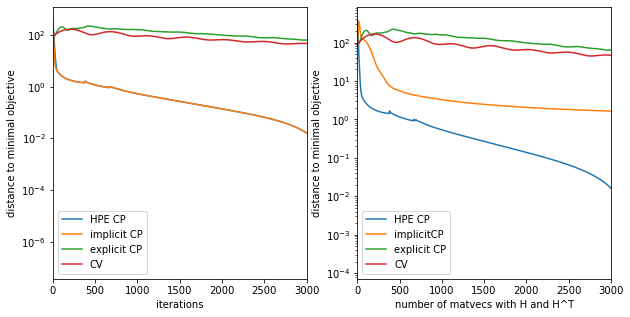

In [4]:
# smaller regularization parameter
lambda_val = 1
# large tolerance for CG in HPE
sigma_HPE = 0.95
name = f'Experiment1CP-objective_{m}x{n}_lambda_{lambda_val}_sigmaHPE_{sigma_HPE}'
experiment1(H,f,lambda_val=lambda_val,maxiter=maxiter,scale_HPE=0.1,sigma_HPE=sigma_HPE,scale_iCP=0.1,scale_CP=0.1,filename=name)

Starting HPE for CP
k = 0, Obj(ztilde): 18.810593, cgiter: 1
k = 300, Obj(ztilde): 0.771609, cgiter: 1
k = 600, Obj(ztilde): 0.469119, cgiter: 1
k = 900, Obj(ztilde): 0.425991, cgiter: 1
k = 1200, Obj(ztilde): 0.420224, cgiter: 1
k = 1500, Obj(ztilde): 0.417331, cgiter: 1
k = 1800, Obj(ztilde): 0.415787, cgiter: 1
k = 2100, Obj(ztilde): 0.414936, cgiter: 1
k = 2400, Obj(ztilde): 0.414412, cgiter: 1
k = 2700, Obj(ztilde): 0.414078, cgiter: 1
k = 3000, Obj(ztilde): 0.413830, cgiter: 1
HPE for CP after 3199 iterations in 100.651818 seconds.
Total numbers of CG iterations: 3200
Final objective: 4.136956e-01.


Starting implicit CP
k = 0, Obj(ztilde): 18.810593, cgiter: 11
k = 300, Obj(ztilde): 0.771609, cgiter: 7
k = 600, Obj(ztilde): 0.469119, cgiter: 6
k = 900, Obj(ztilde): 0.425991, cgiter: 5
k = 1200, Obj(ztilde): 0.420224, cgiter: 4
k = 1500, Obj(ztilde): 0.417331, cgiter: 4
k = 1800, Obj(ztilde): 0.415787, cgiter: 4
k = 2100, Obj(ztilde): 0.414936, cgiter: 4
k = 2400, Obj(ztilde): 0.

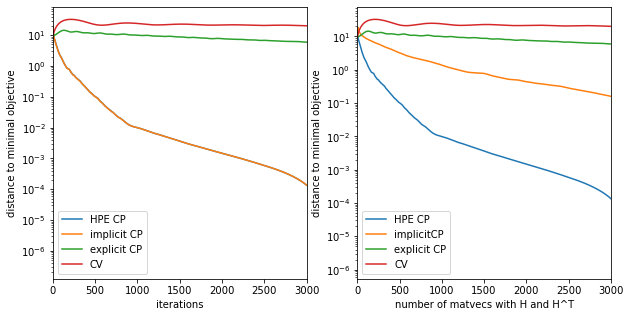

In [5]:
# Second experiment

np.random.seed(183763)
# set up the data
m = 1000
n = 4000

# Some ill conditioned matrix with prescribed spectrum
H = np.random.randn(m,n)
U,S,VT = np.linalg.svd(H)
xx = np.linspace(0,1,min(m,n))
S = np.zeros((m,n))
#np.fill_diagonal(S,0.5+0.5*np.cos(3.1415*xx))
np.fill_diagonal(S,(1-xx)**5)
H = U@S@VT

# Difference matrix
D = np.diag(np.ones(n)) - np.diag(np.ones(n-1), 1)
D = D[:n-1, :]

# f = np.random.randn(m)
t = np.linspace(0, 1, n)
xdag = 0.5 * (np.abs(t - 0.2) < 0.07) + 0.7 * (np.abs(t - 0.6) < 0.2)
f = np.dot(H, xdag) + 0.02 * np.random.randn(m)


lambda_val = 0.1
sigma_HPE = 0.99
name = f'Experiment1CP-objective_{m}x{n}_lambda_{lambda_val}_sigmaHPE_{sigma_HPE}'
experiment1(H,f,lambda_val=lambda_val,maxiter=3000,scale_HPE=0.5,sigma_HPE=sigma_HPE,scale_iCP=0.5,scale_CP=0.5,filename=name)

